# Loan Credit Risk Prediction

When a financial institution examines a request for a loan, it is crucial to assess the risk of default to determine whether to grant it, and if so, what will be the interest rate. 

This notebook takes advantage of the power of SQL Server and RevoScaleR (Microsoft R Server). The tables are all stored in a SQL Server, and most of the computations are done by loading chunks of data in-memory instead of the whole dataset.

It does the following: 

 * **Step 0: Packages, Compute Contexts and Database Creation**
 * **Step 1: Pre-Processing and Cleaning**
 * **Step 2: Feature Engineering**
 * **Step 3: Training, Scoring and Evalutating a Logistic Regression Model**
 * **Step 4: Operational Metrics Computation and Scores Transformation**

## Step 0: Packages, Compute Contexts and Database Creation

#### In this step, we set up the connection string to access a SQL Server Database we create and load the necessary packages. 

In [1]:
# WARNING.
# We recommend not using Internet Explorer as it does not support plotting, and may crash your session.

In [2]:
# INPUT DATA SETS: point to the correct path.  
Loan <- "C:/dsvm/notebooks/Loan.csv"
Borrower <- "C:/dsvm/notebooks/Borrower.csv"

In [3]:
# Load packages.
library(RevoScaleR)
library("MicrosoftML")
library(smbinning)
library(ROCR)

Loading required package: sqldf
Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: DBI
Loading required package: partykit
Loading required package: grid
Loading required package: Formula
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



In [4]:
# Creating the connection string. Specify:
## Database name. If it already exists, tables will be overwritten. If not, it will be created.
## Server name. If conecting remotely to the DSVM, the full DNS address should be used with the port number 1433 (which should be enabled) 
## User ID and Password. Change them below if you modified the default values.  
db_name <- "Loans"
server <- "localhost"
user_id <- "XXYOURSQLUSER"
password <- "XXYOURSQLPW"

connection_string <- sprintf("Driver=SQL Server;Server=%s;Database=%s;UID=%s;PWD=%s", server, db_name, user_id, password)

print("Connection String Written.")

[1] "Connection String Written."


In [5]:
# Create the database if not already existing. 

## Open an Odbc connection with SQL Server master database only to create a new database with the rxExecuteSQLDDL function.
connection_string_master <- sprintf("Driver=SQL Server;Server=%s;Database=master;UID=%s;PWD=%s", server, user_id, password)
outOdbcDS_master <- RxOdbcData(table = "Default_Master", connectionString = connection_string_master)                         
rxOpen(outOdbcDS_master, "w")

## Create database if not already existing. 
query <- sprintf( "if not exists(SELECT * FROM sys.databases WHERE name = '%s') CREATE DATABASE %s;", db_name, db_name)
rxExecuteSQLDDL(outOdbcDS_master, sSQLString = query)

## Close Obdc connection to master database. 
rxClose(outOdbcDS_master)

print("Database created if not already existing.")

[1] TRUE

[1] TRUE

Warning message in rxClose(outOdbcDS_master):
"The datasource is not open yet."

[1] TRUE

[1] "Database created if not already existing."


In [6]:
# Define Compute Contexts.
sql <- RxInSqlServer(connectionString = connection_string)
local <- RxLocalSeq()

# Open a connection with SQL Server to be able to write queries with the rxExecuteSQLDDL function in the new database.
outOdbcDS <- RxOdbcData(table = "Default", connectionString = connection_string)
rxOpen(outOdbcDS, "w")

[1] TRUE

#### The function below can be used to get the top n rows of a table stored on SQL Server. 
#### You can execute this cell throughout your progress by removing the comment "#", and inputting:
#### - the table name.
#### - the number of rows you want to display.

In [7]:
display_head <- function(table_name, n_rows){
   table_sql <- RxSqlServerData(sqlQuery = sprintf("SELECT TOP(%s) * FROM %s", n_rows, table_name), connectionString = connection_string)
   table <- rxImport(table_sql)
   print(table)
}

# table_name <- "insert_table_name"
# n_rows <- 10
# display_head(table_name, n_rows)

## Step 1: Pre-Processing and Cleaning

In this step, we: 

**1.** Upload the 2 raw data sets Loan and Borrower from disk to the SQL Server.

**2.** Join the 2 tables into one.

**3.** Perform a small pre-processing on a few variables.

**4.** Clean the merged data set: we replace NAs with the mode (categorical variables) or mean (continuous variables).

**Input:** 2 Data Tables: Loan and Borrower.

**Output:** Cleaned data set Merged_Cleaned.

In [8]:
# Set the compute context to Local. 
rxSetComputeContext(local)

In [9]:
# Upload the data set to SQL.

## Specify the desired column types. 
## When uploading to SQL, Character and Factor are converted to nvarchar(255), Integer to Integer and Numeric to Float. 
column_types_loan <-  c(loanId = "integer",    
                        memberId = "integer",  
                        date = "character",
                        purpose = "character",
                        isJointApplication = "character",
                        loanAmount = "numeric",
                        term = "character",
                        interestRate = "numeric",
                        monthlyPayment = "numeric",
                        grade = "character",
                        loanStatus = "character")
                          
column_types_borrower <- c(memberId = "integer",  
                           residentialState = "character",
                           yearsEmployment = "character",
                           homeOwnership = "character",
                           annualIncome = "numeric",
                           incomeVerified = "character",
                           dtiRatio = "numeric",
                           lengthCreditHistory = "integer",
                           numTotalCreditLines = "integer",
                           numOpenCreditLines = "integer",
                           numOpenCreditLines1Year = "integer",
                           revolvingBalance = "numeric",
                           revolvingUtilizationRate = "numeric",
                           numDerogatoryRec = "integer",
                           numDelinquency2Years = "integer",
                           numChargeoff1year = "integer",
                           numInquiries6Mon = "integer")
  
## Point to the input data sets while specifying the classes.
Loan_text <- RxTextData(file = Loan, colClasses = column_types_loan)
Borrower_text <- RxTextData(file = Borrower, colClasses = column_types_borrower)
  
## Upload the data to SQL tables. 
Loan_sql <- RxSqlServerData(table = "Loan", connectionString = connection_string)
Borrower_sql <- RxSqlServerData(table = "Borrower", connectionString = connection_string)
  
rxDataStep(inData = Loan_text, outFile = Loan_sql, overwrite = TRUE)
rxDataStep(inData = Borrower_text, outFile = Borrower_sql, overwrite = TRUE)

print("Data exported to SQL.")

Total Rows written: 100000, Total time: 2.697
Rows Read: 100000, Total Rows Processed: 100000, Total Chunk Time: 3.655 seconds 
Total Rows written: 100000, Total time: 2.715
Rows Read: 100000, Total Rows Processed: 100000, Total Chunk Time: 3.565 seconds 
[1] "Data exported to SQL."


In [10]:
# Set the compute context to SQL. 
rxSetComputeContext(sql)

In [11]:
# Inner join of the raw tables Loan and Borrower.
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Merged;"
                                                  , sep=""))
    
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
    "SELECT loanId, [date], purpose, isJointApplication, loanAmount, term, interestRate, monthlyPayment,
            grade, loanStatus, Borrower.*
     INTO Merged
     FROM Loan JOIN Borrower
     ON Loan.memberId = Borrower.memberId;"
      , sep=""))

print("Merging of the two tables completed.")

[1] TRUE

[1] TRUE

[1] "Merging of the two tables completed."


In [12]:
# Determine if Merged has missing values and compute statistics for use in Production. 

## Use rxSummary function to get the names of the variables with missing values.
## Assumption: no NAs in the id variables (loan_id and member_id), target variable and date.
## For rxSummary to give correct info on characters, stringsAsFactors = T should be used. 
Merged_sql <- RxSqlServerData(table = "Merged", connectionString = connection_string, stringsAsFactors = T)
colnames <- rxGetVarNames(Merged_sql)
var <- colnames[!colnames %in% c("loanId", "memberId", "loanStatus", "date")]
formula <- as.formula(paste("~", paste(var, collapse = "+")))
summary <- rxSummary(formula, Merged_sql, byTerm = TRUE)
  
## Get the variables types.
categorical_all <- unlist(lapply(summary$categorical, FUN = function(x){colnames(x)[1]}))
numeric_all <- setdiff(var, categorical_all)
  
## Get the variables names with missing values. 
var_with_NA <- summary$sDataFrame[summary$sDataFrame$MissingObs > 0, 1]
categorical_NA <- intersect(categorical_all, var_with_NA)
numeric_NA <- intersect(numeric_all, var_with_NA)

## Compute the global means. 
Summary_DF <- summary$sDataFrame
Numeric_Means <- Summary_DF[Summary_DF$Name %in% numeric_all, c("Name", "Mean")]
Numeric_Means$Mean  <- round(Numeric_Means$Mean) 
  
## Compute the global modes. 
## Get the counts tables.
Summary_Counts <- summary$categorical
names(Summary_Counts) <- lapply(Summary_Counts, FUN = function(x){colnames(x)[1]})
  
## Compute for each count table the value with the highest count. 
modes <- unlist(lapply(Summary_Counts, FUN = function(x){as.character(x[which.max(x[,2]),1])}), use.names = F)
Categorical_Modes <- data.frame(Name = categorical_all, Mode = modes)
  
## Set the compute context to local to export the summary statistics to SQL. 
## The schema of the Statistics table is adapted to the one created in the SQL code. 
rxSetComputeContext('local')
  
Numeric_Means$Mode <- NA
Numeric_Means$type <- "float" 
  
Categorical_Modes$Mean <- NA
Categorical_Modes$type <- "char"
  
Stats <- rbind(Numeric_Means, Categorical_Modes)[, c("Name", "type", "Mode", "Mean")]
colnames(Stats) <- c("variableName", "type", "mode", "mean")
  
## Save the statistics to SQL for Production use. 
Stats_sql <- RxSqlServerData(table = "Stats", connectionString = connection_string)
rxDataStep(inData = Stats, outFile = Stats_sql, overwrite = TRUE)
  
## Set the compute context back to SQL. 
rxSetComputeContext(sql)  


# If no missing values, we move the data to a new table Merged_Cleaned. 
if(length(var_with_NA) == 0){
    print("No missing values: no treatment will be applied.")
   
    rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Merged_Cleaned;"
                                                  , sep=""))
    
    rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("SELECT * INTO Merged_Cleaned FROM Merged;"
                                                  , sep=""))
    
    missing <- 0     
    
} else{
    print("Variables containing missing values are:")
    print(var_with_NA)
    missing <- 1
    print("Perform data cleaning in the next cell.")
}

Rows Read: 23, Total Rows Processed: 23
Total Rows written: 23, Total time: 0.002
, Total Chunk Time: 0.037 seconds 
[1] "Variables containing missing values are:"
[1] "isJointApplication" "loanAmount"         "term"              
[4] "numOpenCreditLines"
[1] "Perform data cleaning in the next cell."


In [13]:
# If applicable, NULL is replaced with the mode (categorical variables: integer or character) or mean (continuous variables).

if(missing == 1){

    # Get the global means of the numeric variables with missing values.
    numeric_NA_mean <- round(Numeric_Means[Numeric_Means$Name %in% numeric_NA,]$Mean)
    
    # Get the global modes of the categorical variables with missing values. 
    categorical_NA_mode <- as.character(Categorical_Modes[Categorical_Modes$Name %in% categorical_NA,]$Mode)
    
    # Function to replace missing values with mean or mode. It will be wrapped into rxDataStep. 
    Mean_Mode_Replace <- function(data) {
      data <- data.frame(data, stringsAsFactors = F)
      # Replace numeric variables with the mean. 
      if(length(num_with_NA) > 0){
        for(i in 1:length(num_with_NA)){
          row_na <- which(is.na(data[, num_with_NA[i]]) == TRUE) 
          data[row_na, num_with_NA[i]] <- num_NA_mean[i]
        }
      }
      # Replace categorical variables with the mode. 
      if(length(cat_with_NA) > 0){
        for(i in 1:length(cat_with_NA)){
          row_na <- which(is.na(data[, cat_with_NA[i]]) == TRUE) 
          data[row_na, cat_with_NA[i]] <- cat_NA_mode[i]
        }
      }
      return(data)  
    }
    
    # Point to the input table. 
    Merged_sql <- RxSqlServerData(table = "Merged", connectionString = connection_string)
    
    # Point to the output (empty) table. 
    Merged_Cleaned_sql <- RxSqlServerData(table = "Merged_Cleaned", connectionString = connection_string)
      
    # Perform the data cleaning with rxDataStep. 
    rxDataStep(inData = Merged_sql, 
               outFile = Merged_Cleaned_sql, 
               overwrite = T, 
               transformFunc = Mean_Mode_Replace,
               transformObjects = list(num_with_NA = numeric_NA , num_NA_mean = numeric_NA_mean,
                                       cat_with_NA = categorical_NA, cat_NA_mode = categorical_NA_mode))  
 
    print("Data cleaned.")
}

Warning message in `[<-`(`*tmp*`, "outputDataSource", value = <S4 object of class structure("RxSqlServerData", package = "RevoScaleR")>):
"implicit list embedding of S4 objects is deprecated"

[1] "Data cleaned."


## Step 2: Feature Engineering

In this step, we:

**1.** Create the label isBad based on the status of the loan.

**2.** Split the cleaned data set into a Training and a Testing set. 

**3.**  Bucketize all the numeric variables, based on Conditional Inference Trees, using the smbinning package on the Training set. 

**Input:** Cleaned data set Merged_Cleaned.

**Output:** Data set with new features Merged_Features.

In [14]:
# Point to the input table. 
Merged_Cleaned_sql <- RxSqlServerData(table = "Merged_Cleaned", connectionString = connection_string)

# Point to the Output SQL table:
Merged_Labeled_sql <- RxSqlServerData(table = "Merged_Labeled", connectionString = connection_string)
  
# Create the target variable, isBad, based on loanStatus.
rxDataStep(inData = Merged_Cleaned_sql ,
           outFile = Merged_Labeled_sql, 
           overwrite = TRUE, 
           transforms = list(
               isBad = ifelse(loanStatus %in% c("Current"), "0", "1")  
           ))

print("Label isBad created.")

Warning message in `[<-`(`*tmp*`, "outputDataSource", value = <S4 object of class structure("RxSqlServerData", package = "RevoScaleR")>):
"implicit list embedding of S4 objects is deprecated"

[1] "Label isBad created."


In [15]:
# Split the cleaned data set into a Training and a Testing set.

## Create the Hash_Id table containing loanId hashed to integers. 
## The advantage of using a hashing function for splitting is to permit repeatability of the experiment.  
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste("DROP TABLE if exists Hash_Id;", sep = ""))
  
rxExecuteSQLDDL(outOdbcDS, sSQLString = paste(
"SELECT loanId, ABS(CAST(CAST(HashBytes('MD5', CAST(loanId AS varchar(20))) AS VARBINARY(64)) AS BIGINT) % 100) AS hashCode  
INTO Hash_Id
FROM Merged_Labeled ;", sep = ""))
  
# Point to the training set. 
Train_sql <- RxSqlServerData(sqlQuery = 
                            "SELECT *   
                             FROM Merged_Labeled 
                             WHERE loanId IN (SELECT loanId from Hash_Id WHERE hashCode <= 70)",
                            connectionString = connection_string)

print("Splitting completed.")

[1] TRUE

[1] TRUE

[1] "Splitting completed."


In [16]:
# Compute optimal bins for numeric variables using the smbinning package on the Training set. 

# Names of the variables for which we are going to look for the bins with smbinning. 
smb_buckets_names <- c("loanAmount", "interestRate", "monthlyPayment", "annualIncome", "dtiRatio", "lengthCreditHistory",
                       "numTotalCreditLines", "numOpenCreditLines", "numOpenCreditLines1Year", "revolvingBalance",
                       "revolvingUtilizationRate", "numDerogatoryRec", "numDelinquency2Years", "numChargeoff1year", 
                       "numInquiries6Mon")
  
# Using the smbinning has some limitations, such as: 
# - The variable should have more than 10 unique values. 
# - If no significant splits are found, it does not output bins. 
# For this reason, we manually specify default bins based on an analysis of the variables distributions or smbinning on a larger data set. 
# We then overwrite them with smbinning when it output bins. 
  
bins <- list()
  
# Default cutoffs for bins:
# EXAMPLE: If the cutoffs are (c1, c2, c3),
## Bin 1 = ]- inf, c1], Bin 2 = ]c1, c2], Bin 3 = ]c2, c3], Bin 4 = ]c3, + inf] 
## c1 and c3 are NOT the minimum and maximum found in the training set. 
bins$loanAmount <- c(14953, 18951, 20852, 22122, 24709, 28004)
bins$interestRate <- c(7.17, 10.84, 12.86, 14.47, 15.75, 18.05)
bins$monthlyPayment <- c(382, 429, 495, 529, 580, 649, 708, 847)
bins$annualIncome <- c(49402, 50823, 52089, 52885, 53521, 54881, 55520, 57490)
bins$dtiRatio <- c(9.01, 13.42, 15.92, 18.50, 21.49, 22.82, 24.67)
bins$lengthCreditHistory <- c(8)
bins$numTotalCreditLines <- c(1, 2)
bins$numOpenCreditLines <- c(3, 5)
bins$numOpenCreditLines1Year <- c(3, 4, 5, 6, 7, 9)
bins$revolvingBalance <- c(11912, 12645, 13799, 14345, 14785, 15360, 15883, 16361, 17374, 18877)
bins$revolvingUtilizationRate <- c(49.88, 60.01, 74.25, 81.96)
bins$numDerogatoryRec <- c(0, 1)
bins$numDelinquency2Years <- c(0)
bins$numChargeoff1year <- c(0)
bins$numInquiries6Mon <- c(0)
  
# Import the training set to be able to apply smbinning. 
Train_df <- rxImport(Train_sql)
  
# Set the type of the label to numeric. 
Train_df$isBad <- as.numeric(as.character(Train_df$isBad))
  
# Function to compute smbinning on every variable. 
compute_bins <- function(name, data){
 library(smbinning)
 output <- smbinning(data, y = "isBad", x = name, p = 0.05)
 if (class(output) == "list"){ # case where the binning was performed and returned bins.
    cuts <- output$cuts  
    return (cuts)
 }
}
  

# We apply it in parallel accross cores with rxExec and the compute context set to Local Parallel.
## 3 cores will be used here so the code can run on servers with smaller RAM. 
## You can increase numCoresToUse below in order to speed up the execution if using a larger server.
## numCoresToUse = -1 will enable the use of the maximum number of cores.
rxOptions(numCoresToUse = 3) # use 3 cores.
rxSetComputeContext('localpar')
q <- rxExec(compute_bins, name = rxElemArg(smb_buckets_names), data = Train_df)
names(q) <- smb_buckets_names
  
# Fill b with bins obtained in q with smbinning. 
## We replace the default values in b if and only if: 
## - smbinning returned a non NULL result. 
## - there is no repetition in the bins provided by smbinning. 
for(name in smb_buckets_names){
 if (!is.null(q[[name]]) & (length(unique(q[[name]])) == length(q[[name]]))){ 
    bins[[name]] <- q[[name]]
 }
}
  
# Save the bins to SQL for use in Production Stage. 
  
## Open an Odbc connection with SQL Server.
OdbcModel <- RxOdbcData(table = "Bins", connectionString = connection_string)
rxOpen(OdbcModel, "w")
  
## Drop the Bins table if it exists. 
if(rxSqlServerTableExists(OdbcModel@table, OdbcModel@connectionString)) {
    rxSqlServerDropTable(OdbcModel@table, OdbcModel@connectionString)
}
  
## Create an empty Bins table. 
rxExecuteSQLDDL(OdbcModel, 
                sSQLString = paste(" CREATE TABLE [", OdbcModel@table, "] (",
                                     "     [id] varchar(200) not null, ",
                                     "     [value] varbinary(max), ",
                                     "     constraint unique_id unique (id))",
                                     sep = "")
)
  
## Write the model to SQL. 
rxWriteObject(OdbcModel, "Bin Info", bins)
  
## Close the Obdc connection used. 
rxClose(OdbcModel)
  
# Set back the compute context to SQL.
rxSetComputeContext(sql)
  
  
print("Bins computed/defined.")

Rows Read: 50000, Total Rows Processed: 50000, Total Chunk Time: 1.190 seconds
Rows Read: 20907, Total Rows Processed: 70907, Total Chunk Time: 0.502 seconds 


[1] TRUE

[1] TRUE

[1] TRUE

Rows Read: 1, Total Rows Processed: 1
Total Rows written: 1, Total time: 0.002
, Total Chunk Time: 0.028 seconds 


Warning message in rxClose(OdbcModel):
"The datasource is not open yet."

[1] TRUE

[1] "Bins computed/defined."


In [17]:
# Function to bucketize numeric variables. It will be wrapped into rxDataStep. 
Bucketize <- function(data) {
    data <- data.frame(data)
    for(name in  buckets_names){
      # Deal with the last bin.
      name2 <- paste(name, "Bucket", sep = "")
      data[, name2] <- as.character(length(b[[name]]) + 1)
      # Deal with the first bin. 
      rows <- which(data[, name] <= b[[name]][[1]])
      data[rows, name2] <- "1"
      # Deal with the rest.
      if(length(b[[name]]) > 1){
        for(i in seq(1, (length(b[[name]]) - 1))){
          rows <- which(data[, name] <= b[[name]][[i + 1]] & data[, name] > b[[name]][[i]])
          data[rows, name2] <- as.character(i + 1)
        }
      }
    }
    return(data)  
}
  
# Perform feature engineering on the cleaned data set.
   
# Output:
Merged_Features_sql <- RxSqlServerData(table = "Merged_Features", connectionString = connection_string)
    
# Create buckets for various numeric variables with the function Bucketize. 
rxDataStep(inData = Merged_Labeled_sql,
           outFile = Merged_Features_sql, 
           overwrite = TRUE, 
           transformFunc = Bucketize,
           transformObjects =  list(
            b = bins, buckets_names = smb_buckets_names)
           )

print("Feature Engineering Completed.")

Warning message in `[<-`(`*tmp*`, "outputDataSource", value = <S4 object of class structure("RxSqlServerData", package = "RevoScaleR")>):
"implicit list embedding of S4 objects is deprecated"

[1] "Feature Engineering Completed."


## Step 3: Training and Evaluating the Models

In this step we:

**1.** Train a logistic regression classification model on the training set and save it to SQL. 
 
**2.** Score the logisitc regression on the test set. 

**3.** Evaluate the tested model.

**Input:** Data set Merged_Features.

**Output:** Logistic Regression Model, Predictions and Evaluation Metrics. 

In [19]:
# Convert strings to factors.
Merged_Features_sql <- RxSqlServerData(table = "Merged_Features", connectionString = connection_string, stringsAsFactors = T)

## Get the column information. 
column_info <- rxCreateColInfo(Merged_Features_sql, sortLevels = T)

## Set the compute context to local to export the column_info list to SQl. 
rxSetComputeContext('local')
  
## Open an Odbc connection with SQL Server.
OdbcModel <- RxOdbcData(table = "Column_Info", connectionString = connection_string)
rxOpen(OdbcModel, "w")
  
## Drop the Column Info table if it exists. 
if(rxSqlServerTableExists(OdbcModel@table, OdbcModel@connectionString)) {
    rxSqlServerDropTable(OdbcModel@table, OdbcModel@connectionString)
}
  
## Create an empty Column_Info table. 
rxExecuteSQLDDL(OdbcModel, 
                sSQLString = paste(" CREATE TABLE [", OdbcModel@table, "] (",
                                     "     [id] varchar(200) not null, ",
                                     "     [value] varbinary(max), ",
                                     "     constraint unique_id2 unique (id))",
                                     sep = "")
)
  
## Write the model to SQL. 
rxWriteObject(OdbcModel, "Column Info", column_info)
  
## Close the Obdc connection used. 
rxClose(OdbcModel)
  
# Set the compute context back to SQL. 
rxSetComputeContext(sql)
  
# Point to the training set. It will be created on the fly when training models. 
Train_sql <- RxSqlServerData(sqlQuery = 
                               "SELECT *   
                                FROM Merged_Features 
                                WHERE loanId IN (SELECT loanId from Hash_Id WHERE hashCode <= 70)",
                             connectionString = connection_string, colInfo = column_info)
  
# Point to the testing set. It will be created on the fly when testing models. 
Test_sql <- RxSqlServerData(sqlQuery = 
                              "SELECT *   
                               FROM Merged_Features 
                               WHERE loanId NOT IN (SELECT loanId from Hash_Id WHERE hashCode <= 70)",
                            connectionString = connection_string, colInfo = column_info)
  
print("Column information received.")

[1] TRUE

[1] TRUE

[1] TRUE

Rows Read: 1, Total Rows Processed: 1
Total Rows written: 1, Total time: 0.002
, Total Chunk Time: 0.046 seconds 


Warning message in rxClose(OdbcModel):
"The datasource is not open yet."

[1] TRUE

[1] "Column information received."


In [20]:
# Write the formula after removing variables not used in the modeling.
## We remove the id variables, date, residentialState, term, and all the numeric variables that were later bucketed. 
variables_all <- rxGetVarNames(Train_sql)
variables_to_remove <- c("loanId", "memberId", "loanStatus", "date", "residentialState", "term",
                         "loanAmount", "interestRate", "monthlyPayment", "annualIncome", "dtiRatio", "lengthCreditHistory",
                         "numTotalCreditLines", "numOpenCreditLines", "numOpenCreditLines1Year", "revolvingBalance",
                         "revolvingUtilizationRate", "numDerogatoryRec", "numDelinquency2Years", "numChargeoff1year", 
                         "numInquiries6Mon")
  
training_variables <- variables_all[!(variables_all %in% c("isBad", variables_to_remove))]
formula <- as.formula(paste("isBad ~", paste(training_variables, collapse = "+")))

print("Formula written.")

[1] "Formula written."


In [21]:
# Train the logistic regression model.
logistic_model <- rxLogit(formula = formula,
                          data = Train_sql,
                          reportProgress = 0, 
                          initialValues = NA)

## rxLogisticRegression function from the MicrosoftML library can be used instead. 
## The regularization weights (l1Weight and l2Weight) can be modified for further optimization.
## The included selectFeatures function can select a certain number of optimal features based on a specified method.
## the number of variables to select and the method can be further optimized.
  
#library('MicrosoftML')
#logistic_model <- rxLogisticRegression(formula = formula,
#                                       data = Train_sql,
#                                       type = "binary",
#                                       l1Weight = 0.7,
#                                       l2Weight = 0.7,
#                                       mlTransforms = list(selectFeatures(formula, mode = mutualInformation(numFeaturesToKeep = 10))))
  

print("Training Logistic Regression done.")

[1] "Training Logistic Regression done."


In [22]:
# Get the coefficients of the logistic regression formula.
## NA means the variable has been dropped while building the model.
coeff <- logistic_model$coefficients
Logistic_Coeff <- data.frame(variable = names(coeff), coefficient = coeff, row.names = NULL)
  
## Order in decreasing order of absolute value of coefficients. 
Logistic_Coeff <- Logistic_Coeff[order(abs(Logistic_Coeff$coefficient), decreasing = T),]
  
# Write the table to SQL. Compute Context should be set to local. 
rxSetComputeContext(local)
Logistic_Coeff_sql <- RxSqlServerData(table = "Logistic_Coeff", connectionString = connection_string)
rxDataStep(inData = Logistic_Coeff, outFile = Logistic_Coeff_sql, overwrite = TRUE)

print("Logistic Regression Coefficients written to SQL.")

Rows Read: 117, Total Rows Processed: 117
Total Rows written: 117, Total time: 0.004
, Total Chunk Time: 0.045 seconds 
[1] "Logistic Regression Coefficients written to SQL."


In [23]:
# Save the fitted model to SQL Server. 

## Open an Odbc connection with SQL Server.
OdbcModel <- RxOdbcData(table = "Model", connectionString = connection_string)
rxOpen(OdbcModel, "w")
  
## Drop the Model table if it exists. 
if(rxSqlServerTableExists(OdbcModel@table, OdbcModel@connectionString)) {
    rxSqlServerDropTable(OdbcModel@table, OdbcModel@connectionString)
}
  
## Create an empty Model table. 
rxExecuteSQLDDL(OdbcModel, 
                sSQLString = paste(" CREATE TABLE [", OdbcModel@table, "] (",
                                   "  [id] varchar(200) not null, ",
                                   "     [value] varbinary(max), ",
                                   "     constraint unique_id3 unique (id))",
                             sep = "")
                )
  
## Write the model to SQL. 
rxWriteObject(OdbcModel, "Logistic Regression", logistic_model)

## Close Obdc connection. 
rxClose(OdbcModel)

# Set the compute context back to SQL. 
rxSetComputeContext(sql)

print("Model uploaded to SQL.")

[1] TRUE

[1] TRUE

[1] TRUE

Rows Read: 1, Total Rows Processed: 1
Total Rows written: 1, Total time: 0.002
, Total Chunk Time: 0.029 seconds 


Warning message in rxClose(OdbcModel):
"The datasource is not open yet."

[1] TRUE

[1] "Model uploaded to SQL."


In [24]:
# Logistic Regression Scoring

# Make Predictions and save them to SQL.
Predictions_Logistic_sql <- RxSqlServerData(table = "Predictions_Logistic", connectionString = connection_string)
  
rxPredict(logistic_model, 
          data = Test_sql, 
          outData = Predictions_Logistic_sql, 
          overwrite = T, 
          type = "response", # If you used rxLogisticRegression, this argument should be removed. 
          extraVarsToWrite = c("isBad", "loanId"))

print("Scoring done.")

Warning message in `[<-`(`*tmp*`, "outputDataSource", value = <S4 object of class structure("RxSqlServerData", package = "RevoScaleR")>):
"implicit list embedding of S4 objects is deprecated"

RxSqlServerData Source
table: Predictions_Logistic
useFastRead: TRUE
trimSpace: TRUE
connectionString: Driver=SQL Server;Server=localhost;Database=Loans;UID=XXYOURSQLUSER;PWD=XXYOURSQLPW

[1] "Scoring done."


In [25]:
# Evaluation. 

## Import the prediction table and convert is_bad to numeric for correct evaluation. 
Predictions <- rxImport(Predictions_Logistic_sql)
Predictions$isBad <- as.numeric(as.character(Predictions$isBad))

## Change the names of the variables in the predictions table if you used rxLogisticRegression.
## Predictions <- Predictions[, c(1, 2, 5)]
## colnames(Predictions) <- c("isBad", "loanId", "isBad_Pred")

## Set the Compute Context to local for evaluation. 
rxSetComputeContext(local)
    
print("Predictions imported.")

Rows Read: 29093, Total Rows Processed: 29093, Total Chunk Time: 0.067 seconds 
[1] "Predictions imported."


[1] "KS = 0.670090495378362"


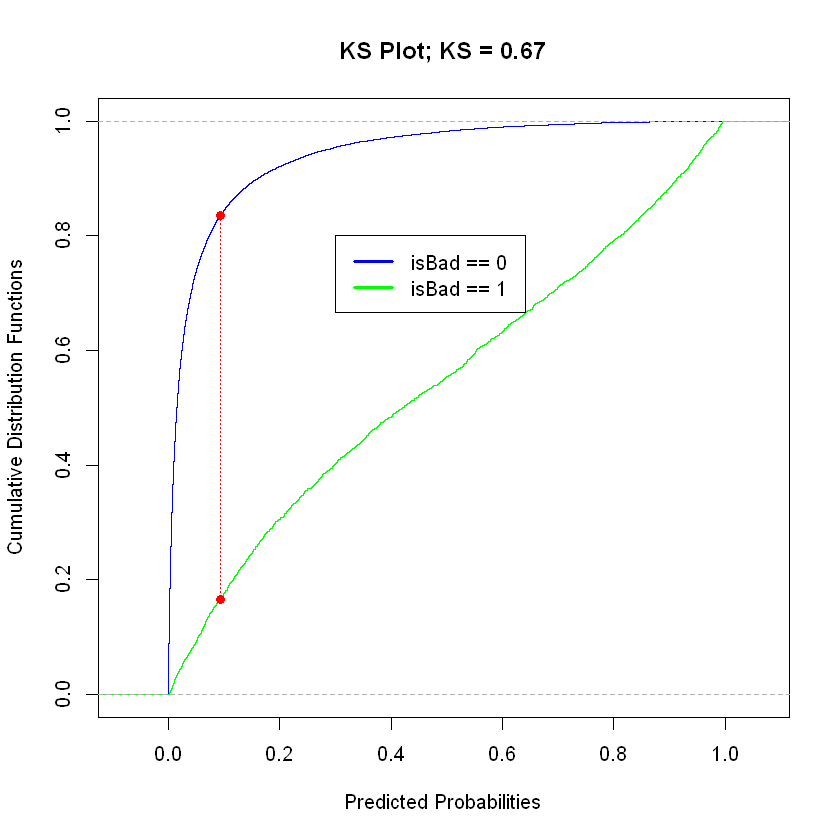

In [26]:
## KS PLOT AND STATISTIC.

# Split the data according to the observed value and get the cumulative distribution of predicted probabilities. 
Predictions0 <- Predictions[Predictions$isBad==0,]$isBad_Pred
Predictions1 <- Predictions[Predictions$isBad==1,]$isBad_Pred
    
cdf0 <- ecdf(Predictions0)
cdf1 <- ecdf(Predictions1)
    
# Compute the KS statistic and the corresponding points on the KS plot. 
    
## Create a sequence of predicted probabilities in its range of values. 
minMax <- seq(min(Predictions0, Predictions1), max(Predictions0, Predictions1), length.out=length(Predictions0)) 
    
## Compute KS, ie. the largest distance between the two cumulative distributions. 
KS <- max(abs(cdf0(minMax) - cdf1(minMax))) 
print(sprintf("KS = %s", KS))
    
## Find a predicted probability where the cumulative distributions have the biggest difference.  
x0 <- minMax[which(abs(cdf0(minMax) - cdf1(minMax)) == KS )][1] 
    
## Get the corresponding points on the plot. 
y0 <- cdf0(x0) 
y1 <- cdf1(x0) 
    
# Plot the two cumulative distributions with the line between points of greatest distance. 
plot(cdf0, verticals=TRUE, do.points=FALSE, col="blue", main = sprintf("KS Plot; KS = %s", round(KS, digits = 3)), ylab = "Cumulative Distribution Functions", xlab = "Predicted Probabilities") 
plot(cdf1, verticals=TRUE, do.points=FALSE, col="green", add=TRUE) 
legend(0.3, 0.8, c("isBad == 0", "isBad == 1"), lty = c(1, 1), lwd = c(2.5, 2.5), col = c("blue", "green"))
points(c(x0, x0), c(y0, y1), pch=16, col="red") 
segments(x0, y0, x0, y1, col="red", lty="dotted") 


In [27]:
## CONFUSION MATRIX AND VARIOUS METRICS. 

# The cumulative distributions of predicted probabilities given observed values are the farthest apart for a score equal to x0.
# We can then use x0 as a decision threshold for example. 
# Note that the choice of a decision threshold can be further optimized.
    
# Using the x0 point as a threshold, we compute the binary predictions to get the confusion matrix. 
Predictions$isBad_Pred_Binary <- ifelse(Predictions$isBad_Pred < x0, 0, 1)
    
confusion <- table(Predictions$isBad, Predictions$isBad_Pred_Binary, dnn = c("Observed", "Predicted"))[c("0", "1"), c("0", "1")]
print(confusion) 
tp <- confusion[1, 1] 
fn <- confusion[1, 2] 
fp <- confusion[2, 1] 
tn <- confusion[2, 2] 
accuracy <- (tp + tn) / (tp + fn + fp + tn) 
precision <- tp / (tp + fp) 
recall <- tp / (tp + fn) 
fscore <- 2 * (precision * recall) / (precision + recall) 

# Print the computed metrics.
metrics <- c("Accuracy" = accuracy, 
             "Precision" = precision, 
             "Recall" = recall, 
             "F-Score" = fscore,
             "Score Threshold" = x0) 

print(metrics)


        Predicted
Observed     0     1
       0 21860  4302
       1   485  2446
       Accuracy       Precision          Recall         F-Score Score Threshold 
     0.83545870      0.97829492      0.83556303      0.90131321      0.09325882 


[1] "AUC = 0.912732475663863"


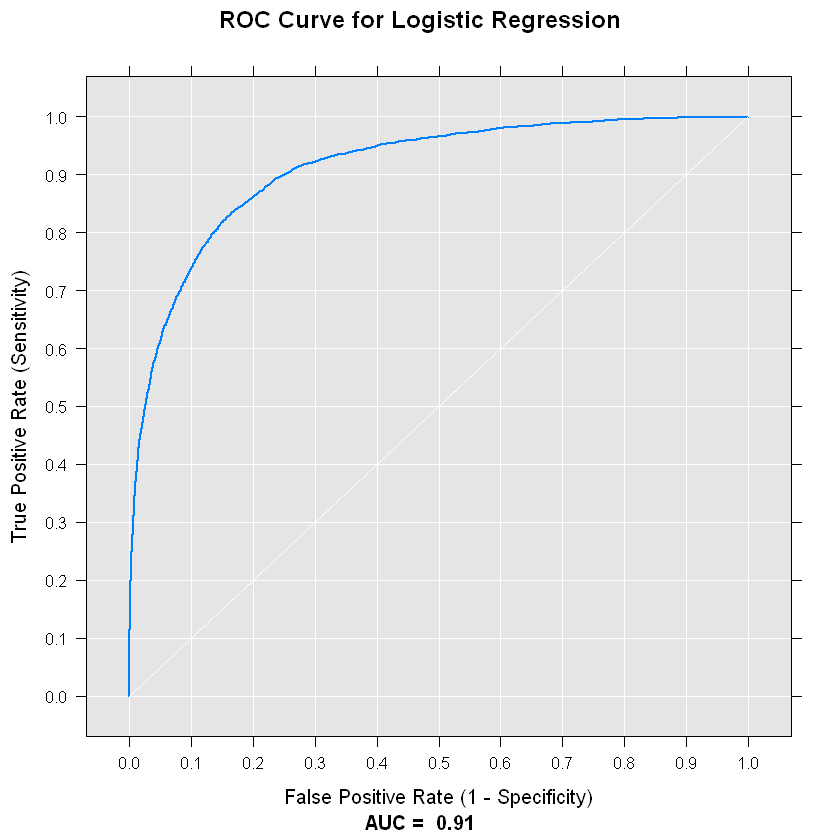

In [28]:
## ROC PLOT AND AUC.

ROC <- rxRoc(actualVarName = "isBad", predVarNames = "isBad_Pred", data = Predictions, numBreaks = 1000)
AUC <- rxAuc(ROC)
print(sprintf("AUC = %s", AUC))
plot(ROC, title = "ROC Curve for Logistic Regression")
    

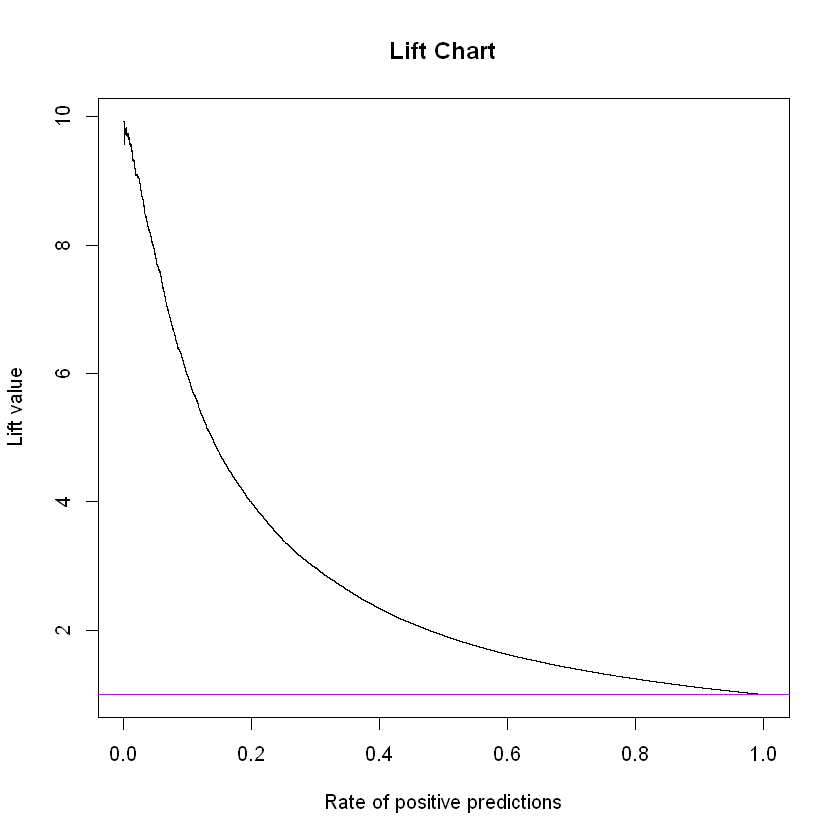

In [29]:
## LIFT CHART. 

pred <- prediction(predictions = Predictions$isBad_Pred, labels = Predictions$isBad, label.ordering = c("0", "1"))
perf <- performance(pred,  measure = "lift", x.measure = "rpp") 
plot(perf, main = c("Lift Chart"))
abline(h = 1.0, col = "purple")

## Step 4: Operational Metrics Computation and Scores Transformation

In this step, we: 

**1.** Compute Operational Metrics: expected bad rate for various classification decision thresholds.  

**2.** Apply a score transformation based on operational metrics. 

**Input:** Predictions table.

**Output:** Operational Metrics and Transformed Scores.

### Operational metrics are computed in the following way:

**1.** Apply a sigmoid function to the output scores of the logistic regression, in order to spread them in [0,1].

**2.** Compute bins for the scores, based on quantiles. 

**3.** Take each lower bound of each bin as a decision threshold for default loan classification, and compute the rate of bad loans among loans with a score higher than the threshold. 

In [31]:
# Space out the scores (predicted probability of default) for interpretability with a sigmoid.
## Define the sigmoid: it is centered at 1.2*mean score to ensure a good spread of scores.  
dev_test_avg_score <- mean(Predictions$isBad_Pred)
sigmoid <- function(x){
 return(1/(1 + exp(-20*(x-1.2*dev_test_avg_score))))
}
  
## Apply the function.
Predictions$transformedScore <- sigmoid(Predictions$isBad_Pred)

## Changes can be observed with the histograms and summary statistics.
#summary(Predictions$isBad_Pred)
#hist(Predictions$isBad_Pred)
#summary(Predictions$transformedScore)
#hist(Predictions$transformedScore)

## Save the average score on the test set for the Production stage. 
Scores_Average <- data.frame(avg = dev_test_avg_score)
Scores_Average_sql <- RxSqlServerData(table = "Scores_Average", connectionString = connection_string)
rxDataStep(inData = Scores_Average, outFile = Scores_Average_sql, overwrite = TRUE)
  
print("Scores Spaced out in [0,1]")

Rows Read: 1, Total Rows Processed: 1
Total Rows written: 1, Total time: 0.002
, Total Chunk Time: 0.039 seconds 
[1] "Scores Spaced out in [0,1]"


In [32]:
# Compute operational metrics.
  
## Bin the scores based on quantiles. 
bins <- rxQuantile("transformedScore", Predictions, probs = c(seq(0, 0.99, 0.01))) 
bins[["0%"]] <- 0 
  
## We consider 100 decision thresholds: the lower bound of each bin.
## Compute the expected rates of bad loans for loans with scores higher than each decision threshold. 
badrate <- rep(0, length(bins))
for(i in 1:length(bins))
{
 selected <- Predictions$isBad[Predictions$transformedScore >= bins[i]]
 badrate[i] <- sum(selected)/length(selected) 
}
  
## Save the data points to a data frame and load it to SQL.  
Operational_Metrics <- data.frame(scorePercentile = names(bins), scoreCutoff = bins, badRate = badrate, row.names = NULL)
Operational_Metrics_sql <- RxSqlServerData(table = "Operational_Metrics", connectionString = connection_string)
rxDataStep(inData = Operational_Metrics, outFile = Operational_Metrics_sql, overwrite = TRUE)
  
print("Operational Metrics computed.")

Rows Read: 29093, Total Rows Processed: 29093, Total Chunk Time: 0.003 seconds 
Computation time: 0.007 seconds.
Rows Read: 100, Total Rows Processed: 100
Total Rows written: 100, Total time: 0.004
, Total Chunk Time: 0.040 seconds 
[1] "Operational Metrics computed."


In [33]:
# Apply the score transformation. 
  
## Deal with the bottom 1-99 percentiles. 
for (i in seq(1, (nrow(Operational_Metrics) - 1))){
 rows <- which(Predictions$transformedScore <= Operational_Metrics$scoreCutoff[i + 1] & 
               Predictions$transformedScore > Operational_Metrics$scoreCutoff[i])
 Predictions[rows, c("scorePercentile")] <- as.character(Operational_Metrics$scorePercentile[i + 1])
 Predictions[rows, c("badRate")] <- Operational_Metrics$badRate[i]
 Predictions[rows, c("scoreCutoff")] <- Operational_Metrics$scoreCutoff[i]
}
  
## Deal with the top 1% higher scores (last bucket). 
rows <- which(Predictions$transformedScore > Operational_Metrics$scoreCutoff[100])
Predictions[rows, c("scorePercentile")] <- "Top 1%"
Predictions[rows, c("scoreCutoff")] <- Operational_Metrics$scoreCutoff[100]
Predictions[rows, c("badRate")] <- Operational_Metrics$badRate[100]
 
## Save the transformed scores to SQL. 
Scores_sql <- RxSqlServerData(table = "Scores", connectionString = connection_string)
rxDataStep(inData = Predictions[, c("loanId", "transformedScore", "scorePercentile", "scoreCutoff", "badRate", "isBad")], 
           outFile = Scores_sql, 
           overwrite = TRUE)

print("Scores transformed.")

Rows Read: 29093, Total Rows Processed: 29093
Total Rows written: 29093, Total time: 0.6
, Total Chunk Time: 0.651 seconds 
[1] "Scores transformed."


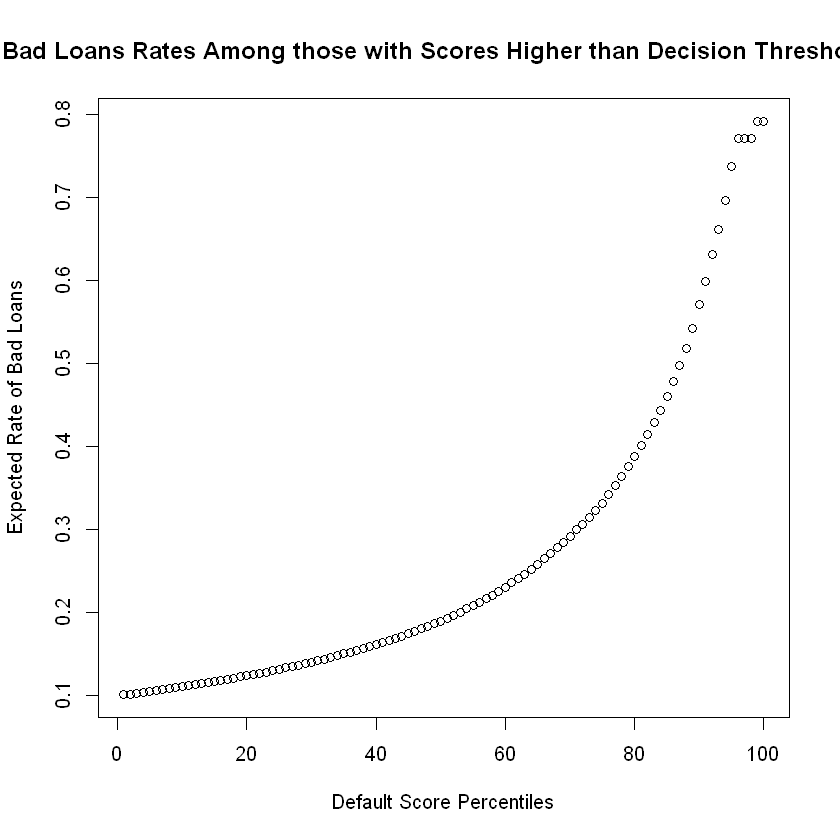

In [34]:
# Plot the rates of bad loans for various thresholds obtained through binning.  
plot(Operational_Metrics$badRate, main = c("Bad Loans Rates Among those with Scores Higher than Decision Thresholds"), xlab = "Default Score Percentiles", ylab = "Expected Rate of Bad Loans")

## EXAMPLE: 
## If the score cutoff of the 91th score percentile is 0.9834, and we read a bad rate of 0.6449.  
## This means that if 0.9834 is used as a threshold to classify loans as bad, we would have a bad rate of 64.49%.  
## This bad rate is equal to the number of observed bad loans over the total number of loans with a score greater than the threshold. 


In [35]:
# Close Obdc connection to master database. 
rxClose(outOdbcDS)

Warning message in rxClose(outOdbcDS):
"The datasource is not open yet."

[1] TRUE